In [4]:
from zipfile import ZipFile

folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'
output = folder + endpoint

with ZipFile(output, 'r') as zObject:
	zObject.extractall(folder)

In [5]:
import os

folder = 'nfl-big-data-bowl-2024'
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [6]:
import pandas as pd
dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}
# Unificar
df_joined = pd.concat(dfs[f'tracking_week_{i}'] for i in range(1, 10))

KeyboardInterrupt: 

In [ ]:
df_joined[['gameId', 'playId']].drop_duplicates()

,gameId,playId
0,2022090800,56
506,2022090800,80
1196,2022090800,101
2323,2022090800,122
3082,2022090800,146
...,...,...
1143606,2022110700,3658
1144963,2022110700,3686
1146711,2022110700,3707
1148045,2022110700,3740


In [ ]:
df = df_joined.drop(columns=['displayName', 'jerseyNumber', 'time'])
df.head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,2,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,3,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,4,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,5,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


A continuación se eliminan frames no útiles para nuestra red

In [ ]:
# Variables de filtrado
play_condition = (df['event'] == 'pass_forward') | (df['event'] == 'pass_shovel') | (df['event'] == 'run')
play_id_fields = ('gameId', 'playId')
event_id_fields = (*play_id_fields, 'frameId')

# Obtener Ids de la jugada
event_ids = df.loc[play_condition, event_id_fields]
event_ids.drop_duplicates(inplace=True)

# Eliminar jugadas que no contienen alguno de los 3 eventos
df = pd.merge(df, event_ids.loc[:, play_id_fields], on=play_id_fields, how='inner')

# Columna auxiliar que indica en que momento ocurre el evento
df = pd.merge(df, event_ids, on=play_id_fields, suffixes=('', 'Event'))

# Eliminar frames a partir del evento
df = df.loc[df.loc[:, 'frameId'] <= df.loc[:, 'frameIdEvent'], :]
df.head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,event,frameIdEvent
0,2022090800,80,35472.0,1,BUF,left,82.42,26.13,2.43,0.37,0.24,196.42,140.67,NaN,6
1,2022090800,80,35472.0,2,BUF,left,82.58,25.96,2.34,0.93,0.24,203.85,138.66,NaN,6
2,2022090800,80,35472.0,3,BUF,left,82.73,25.79,2.20,1.39,0.22,209.50,136.40,NaN,6
3,2022090800,80,35472.0,4,BUF,left,82.87,25.66,1.96,1.87,0.20,214.57,133.71,NaN,6
4,2022090800,80,35472.0,5,BUF,left,82.99,25.55,1.62,2.42,0.16,222.35,130.47,NaN,6


Cambiamos los valores de la pelota NA por 0

In [ ]:
# Orientación de la pelota utilizamos 0
df['dir'] = df['dir'].fillna(0)
df['o'] = df['o'].fillna(0)
df.loc[df.loc[:, 'club'] == 'football', :].head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,event,frameIdEvent
660,2022090800,80,NaN,1,football,left,83.470001,30.459999,0.85,3.46,0.08,0.0,0.0,NaN,6
661,2022090800,80,NaN,2,football,left,83.330002,30.559999,1.93,8.59,0.18,0.0,0.0,NaN,6
662,2022090800,80,NaN,3,football,left,83.139999,30.740000,3.03,9.67,0.26,0.0,0.0,NaN,6
663,2022090800,80,NaN,4,football,left,82.900002,30.990000,4.01,8.54,0.35,0.0,0.0,NaN,6
664,2022090800,80,NaN,5,football,left,82.599998,31.320000,5.02,8.34,0.45,0.0,0.0,NaN,6


Cambiamos el playDirection para que tome valor 0 ó 1 en vez de cadena

In [ ]:
df['playDirection'] = df['playDirection'].replace({'left': 0, 'right': 1})
df.head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir,event,frameIdEvent
0,2022090800,80,35472.0,1,BUF,0,82.42,26.13,2.43,0.37,0.24,196.42,140.67,NaN,6
1,2022090800,80,35472.0,2,BUF,0,82.58,25.96,2.34,0.93,0.24,203.85,138.66,NaN,6
2,2022090800,80,35472.0,3,BUF,0,82.73,25.79,2.20,1.39,0.22,209.50,136.40,NaN,6
3,2022090800,80,35472.0,4,BUF,0,82.87,25.66,1.96,1.87,0.20,214.57,133.71,NaN,6
4,2022090800,80,35472.0,5,BUF,0,82.99,25.55,1.62,2.42,0.16,222.35,130.47,NaN,6


Añadimos columnas relevantes

In [ ]:
# Variables relevantes en la jugada
# intento, yardas restantes, linea de yardas, cuarto
play_relevant_vars = ('down', 'yardsToGo', 'yardlineNumber', 'quarter')

for var in play_relevant_vars:
    df = pd.merge(df, dfs['plays'].loc[:, (var, *play_id_fields)], on=play_id_fields, how='left')

# Posicion del jugador
df = pd.merge(df, dfs['players'].loc[:, ('position', 'nflId')], on='nflId', how='left')

# Jugadores designados como receptores
df['allowedReceiver'] = 0
df.loc[(df['position'] == 'QB')|(df['position'] == 'TE')|(df['position'] == 'WR')|(df['position'] == 'RB'), 'allowedReceiver'] = 1

# Local o visitante
df = pd.merge(df, dfs['games'].loc[:, ('homeTeamAbbr', 'gameId')], on='gameId', how='left')
df.loc[df.loc[:, 'club'] == df.loc[:, 'homeTeamAbbr'], 'local'] = 1
df.loc[df.loc[:, 'club'] == 'football', 'local'] = 0
df.loc[df.loc[:, 'club'] != df.loc[:, 'homeTeamAbbr'], 'local'] = -1

df.head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,...,event,frameIdEvent,down,yardsToGo,yardlineNumber,quarter,position,allowedReceiver,homeTeamAbbr,local
0,2022090800,80,35472.0,1,BUF,0,82.42,26.13,2.43,0.37,...,NaN,6,2,4,31,1,G,0,LA,-1.0
1,2022090800,80,35472.0,2,BUF,0,82.58,25.96,2.34,0.93,...,NaN,6,2,4,31,1,G,0,LA,-1.0
2,2022090800,80,35472.0,3,BUF,0,82.73,25.79,2.20,1.39,...,NaN,6,2,4,31,1,G,0,LA,-1.0
3,2022090800,80,35472.0,4,BUF,0,82.87,25.66,1.96,1.87,...,NaN,6,2,4,31,1,G,0,LA,-1.0
4,2022090800,80,35472.0,5,BUF,0,82.99,25.55,1.62,2.42,...,NaN,6,2,4,31,1,G,0,LA,-1.0


Etiqueta de quién es el receptor en la jugada

In [ ]:
# Etiqueta
df = pd.merge(df, dfs['plays'].loc[:, ('ballCarrierId', 'playId', 'gameId')], on=('playId', 'gameId'), how='left')
df['ballCarrier'] = df['nflId'] == df['ballCarrierId']
df['ballCarrier'] = df['ballCarrier'].astype(int)
df.head()

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,...,down,yardsToGo,yardlineNumber,quarter,position,allowedReceiver,homeTeamAbbr,local,ballCarrierId,ballCarrier
0,2022090800,80,35472.0,1,BUF,0,82.42,26.13,2.43,0.37,...,2,4,31,1,G,0,LA,-1.0,46076,0
1,2022090800,80,35472.0,2,BUF,0,82.58,25.96,2.34,0.93,...,2,4,31,1,G,0,LA,-1.0,46076,0
2,2022090800,80,35472.0,3,BUF,0,82.73,25.79,2.20,1.39,...,2,4,31,1,G,0,LA,-1.0,46076,0
3,2022090800,80,35472.0,4,BUF,0,82.87,25.66,1.96,1.87,...,2,4,31,1,G,0,LA,-1.0,46076,0
4,2022090800,80,35472.0,5,BUF,0,82.99,25.55,1.62,2.42,...,2,4,31,1,G,0,LA,-1.0,46076,0


In [ ]:
# Ordenamos, lo que lleva a que la columna local sea irrelevante
df.sort_values(by=['gameId', 'playId', 'frameId', 'local'], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,...,down,yardsToGo,yardlineNumber,quarter,position,allowedReceiver,homeTeamAbbr,local,ballCarrierId,ballCarrier
0,2022090800,80,35472.0,1,BUF,0,82.42,26.13,2.43,0.37,...,2,4,31,1,G,0,LA,-1.0,46076,0
1,2022090800,80,42392.0,1,BUF,0,81.75,28.39,1.18,2.36,...,2,4,31,1,C,0,LA,-1.0,46076,0
2,2022090800,80,42489.0,1,BUF,0,69.42,22.59,5.78,5.05,...,2,4,31,1,WR,1,LA,-1.0,46076,0
3,2022090800,80,44875.0,1,BUF,0,82.93,24.59,1.04,3.38,...,2,4,31,1,T,0,LA,-1.0,46076,0
4,2022090800,80,44985.0,1,BUF,0,72.64,8.50,5.55,4.09,...,2,4,31,1,WR,1,LA,-1.0,46076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287449,2022110700,3581,48537.0,20,NO,0,81.44,27.81,0.44,2.11,...,2,4,28,4,DE,0,NO,1.0,46101,0
287450,2022110700,3581,48544.0,20,NO,0,81.52,29.75,0.52,1.07,...,2,4,28,4,DT,0,NO,1.0,46101,0
287451,2022110700,3581,52482.0,20,NO,0,83.55,20.72,5.13,0.99,...,2,4,28,4,OLB,0,NO,1.0,46101,0
287452,2022110700,3581,53505.0,20,NO,0,78.52,44.18,3.30,2.74,...,2,4,28,4,CB,0,NO,1.0,46101,0


In [ ]:
columnas = ['x','y','s','a','dis','o','dir','down','yardsToGo','yardlineNumber','quarter']
ds = df.loc[:, :]
for columna in columnas:
  # Normalización min-max
  min_val = ds[columna].min()
  max_val = ds[columna].max()
  ds[columna] = (ds[columna] - min_val) / (max_val - min_val)

In [ ]:
import tensorflow as tf

numeric_feature_names = ['playDirection', 'x','y','s','a','dis','o','dir','down','yardsToGo','yardlineNumber','allowedReceiver','quarter']
numeric_features = ds[numeric_feature_names]

snapshots = tf.convert_to_tensor(numeric_features)
snapshots = tf.reshape(snapshots, (-1, 23, 13))

target = 'ballCarrier'
label_features = ds[target]
labels = tf.convert_to_tensor(label_features)
labels = tf.reshape(labels, (-1, 23))
snapshots.shape, labels.shape

(TensorShape([12498, 23, 13]), TensorShape([12498, 23]))

In [ ]:
ds_nfl =  tf.data.Dataset.from_tensor_slices((snapshots, labels))
ds_nfl

<_TensorSliceDataset element_spec=(TensorSpec(shape=(23, 13), dtype=tf.float64, name=None), TensorSpec(shape=(23,), dtype=tf.int32, name=None))>

In [ ]:
for elem in ds_nfl.take(1):
  print(elem)

(<tf.Tensor: shape=(23, 13), dtype=float64, numpy=
array([[0.        , 0.67738194, 0.46672598, 0.11516587, 0.01435221,
        0.0609137 , 0.54561111, 0.39075   , 0.33333333, 0.125     ,
        0.6122449 , 0.        , 0.        ],
       [0.        , 0.67183099, 0.5069395 , 0.05592417, 0.09154383,
        0.03299492, 0.75333333, 0.95644444, 0.33333333, 0.125     ,
        0.6122449 , 0.        , 0.        ],
       [0.        , 0.56967688, 0.40373665, 0.27393364, 0.19588828,
        0.14720812, 0.82991667, 0.79963889, 0.33333333, 0.125     ,
        0.6122449 , 1.        , 0.        ],
       [0.        , 0.68160729, 0.43932384, 0.0492891 , 0.13110938,
        0.03045685, 0.68516667, 0.365     , 0.33333333, 0.125     ,
        0.6122449 , 0.        , 0.        ],
       [0.        , 0.5963546 , 0.15302491, 0.26303317, 0.15865011,
        0.14467005, 0.80427778, 0.64616667, 0.33333333, 0.125     ,
        0.6122449 , 1.        , 0.        ],
       [0.        , 0.68881524, 0.53807829, 

In [ ]:
num_train = len(ds_nfl)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_nfl.skip(test_size)
ds_test = ds_nfl.take(test_size)

In [ ]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_nfl.skip(validation_size)
ds_val = ds_nfl.take(validation_size)

In [ ]:
# def normalize(snapshot, label):
#     # Calcular la media y la desviación estándar por columnas
#     mean = tf.reduce_mean(snapshot, axis=0)
#     std_dev = tf.math.reduce_std(snapshot, axis=0)

#     # Normalizar por columnas
#     normalized_tensor = (snapshot - mean) / std_dev

#     return normalized_tensor, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    #.map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    #.map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = (early_stopping, )

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

# Arquitectura de la red convolucional
model = models.Sequential()
model.add(layers.Input(shape=(23, 13)))

# Capa de convolución 1D con padding 'same' para mantener la longitud original de la secuencia
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))

# Capa de aplanado para conectar con una capa densa
model.add(layers.Flatten())

# Capa densa con Batch Normalization
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Capa de salida
model.add(layers.Dense(23, activation='softmax', kernel_regularizer=l2(0.01)))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen de la arquitectura del modelo
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 23, 64)            2560      
                                                                 
 dropout_20 (Dropout)        (None, 23, 64)            0         
                                                                 
 flatten_10 (Flatten)        (None, 1472)              0         
                                                                 
 dense_20 (Dense)            (None, 128)               188544    
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                     

In [ ]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

Epoch 1/100


11/11 [==============================] - 2s 47ms/step - loss: 6.4361 - accuracy: 0.1000 - val_loss: 5.3916 - val_accuracy: 0.1721
Epoch 2/100
11/11 [==============================] - 0s 23ms/step - loss: 5.0231 - accuracy: 0.2324 - val_loss: 4.8464 - val_accuracy: 0.2266
Epoch 3/100
11/11 [==============================] - 0s 23ms/step - loss: 4.2220 - accuracy: 0.3383 - val_loss: 4.5011 - val_accuracy: 0.2326
Epoch 4/100
11/11 [==============================] - 0s 24ms/step - loss: 3.6767 - accuracy: 0.4127 - val_loss: 4.3243 - val_accuracy: 0.2671
Epoch 5/100
11/11 [==============================] - 0s 24ms/step - loss: 3.2207 - accuracy: 0.4993 - val_loss: 4.2309 - val_accuracy: 0.2766
Epoch 6/100
11/11 [==============================] - 0s 24ms/step - loss: 2.8502 - accuracy: 0.5653 - val_loss: 4.1293 - val_accuracy: 0.2656
Epoch 7/100
11/11 [==============================] - 0s 22ms/step - loss: 2.5624 - accuracy: 0.6193 - val_loss: 4.0211 - val_accuracy: 0.2616
Epoch 8/100
11/11 

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    #.map(normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)

 1/20 [>.............................] - ETA: 0s - loss: 2.5230 - accuracy: 0.6016

20/20 [==============================] - 0s 3ms/step - loss: 2.2616 - accuracy: 0.4726
Test accuracy: 0.47258904576301575


In [ ]:
jugadas_seleccionadas = df.drop_duplicates(subset=('gameId', 'playId'))
jugadas_seleccionadas[['gameId', 'playId', 'frameIdEvent']].head(10)

,gameId,playId,frameIdEvent
0,2022090800,80,6
138,2022090800,1757,6
276,2022090800,2093,20
736,2022090800,2137,6
874,2022090800,2464,6
1012,2022090800,2648,23
1541,2022090800,2712,24
2093,2022090800,2755,6
2231,2022090800,2839,39
3128,2022090800,2958,22


In [ ]:
game_id = 2022090800

play_id = 2958

idname = str(game_id) + '_' + str(play_id)

In [ ]:
play = df.loc[(df['gameId'] == game_id) & (df['playId'] == play_id)]
play

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,...,down,yardsToGo,yardlineNumber,quarter,position,allowedReceiver,homeTeamAbbr,local,ballCarrierId,ballCarrier
3128,2022090800,2958,35472.0,1,BUF,1,51.24,25.45,0.00,0.00,...,2,9,42,4,G,0,LA,-1.0,46076,0
3129,2022090800,2958,42392.0,1,BUF,1,51.47,23.79,0.00,0.00,...,2,9,42,4,C,0,LA,-1.0,46076,0
3130,2022090800,2958,42448.0,1,BUF,1,50.08,35.16,0.00,0.00,...,2,9,42,4,WR,1,LA,-1.0,46076,0
3131,2022090800,2958,44875.0,1,BUF,1,51.32,26.97,0.00,0.00,...,2,9,42,4,T,0,LA,-1.0,46076,0
3132,2022090800,2958,44985.0,1,BUF,1,50.57,31.88,0.00,0.00,...,2,9,42,4,WR,1,LA,-1.0,46076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,2022090800,2958,47844.0,22,LA,1,60.40,39.19,2.86,0.65,...,2,9,42,4,FS,0,LA,1.0,46076,0
3630,2022090800,2958,47917.0,22,LA,1,51.76,25.48,1.11,1.09,...,2,9,42,4,NT,0,LA,1.0,46076,0
3631,2022090800,2958,48026.0,22,LA,1,70.67,29.17,3.97,0.81,...,2,9,42,4,SS,0,LA,1.0,46076,0
3632,2022090800,2958,52607.0,22,LA,1,62.35,22.73,0.66,3.83,...,2,9,42,4,SS,0,LA,1.0,46076,0


In [ ]:
play_normalized = ds.loc[(df['gameId'] == game_id) & (df['playId'] == play_id)]
play_normalized

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,...,down,yardsToGo,yardlineNumber,quarter,position,allowedReceiver,homeTeamAbbr,local,ballCarrierId,ballCarrier
3128,2022090800,2958,35472.0,1,BUF,1,0.419056,0.454626,0.000000,0.000000,...,0.333333,0.333333,0.836735,0.75,G,0,LA,-1.0,46076,0
3129,2022090800,2958,42392.0,1,BUF,1,0.420961,0.425089,0.000000,0.000000,...,0.333333,0.333333,0.836735,0.75,C,0,LA,-1.0,46076,0
3130,2022090800,2958,42448.0,1,BUF,1,0.409445,0.627402,0.000000,0.000000,...,0.333333,0.333333,0.836735,0.75,WR,1,LA,-1.0,46076,0
3131,2022090800,2958,44875.0,1,BUF,1,0.419718,0.481673,0.000000,0.000000,...,0.333333,0.333333,0.836735,0.75,T,0,LA,-1.0,46076,0
3132,2022090800,2958,44985.0,1,BUF,1,0.413505,0.569039,0.000000,0.000000,...,0.333333,0.333333,0.836735,0.75,WR,1,LA,-1.0,46076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,2022090800,2958,47844.0,22,LA,1,0.494946,0.699110,0.135545,0.025213,...,0.333333,0.333333,0.836735,0.75,FS,0,LA,1.0,46076,0
3630,2022090800,2958,47917.0,22,LA,1,0.423364,0.455160,0.052607,0.042281,...,0.333333,0.333333,0.836735,0.75,NT,0,LA,1.0,46076,0
3631,2022090800,2958,48026.0,22,LA,1,0.580033,0.520819,0.188152,0.031420,...,0.333333,0.333333,0.836735,0.75,SS,0,LA,1.0,46076,0
3632,2022090800,2958,52607.0,22,LA,1,0.511102,0.406228,0.031280,0.148565,...,0.333333,0.333333,0.836735,0.75,SS,0,LA,1.0,46076,0


In [ ]:
import numpy as np
numeric_feature_names = [
    'playDirection', 'x','y','s','a','dis','o','dir','down','yardsToGo','yardlineNumber','allowedReceiver','quarter']
numeric_features = play_normalized[numeric_feature_names]

snapshots = tf.convert_to_tensor(numeric_features)
snapshots = tf.reshape(snapshots, (-1, 23, 13))

target = 'ballCarrier'
label_features = play_normalized[target]
labels = tf.convert_to_tensor(label_features)
labels = tf.reshape(labels, (-1, 23))

ds_play =  tf.data.Dataset.from_tensor_slices((snapshots, labels))
BATCH_SIZE = 1
ds_play = (
    ds_play.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
predictions = []
probability = []
real = []
for snapshot, label in ds_play:
    prediction = model.predict(snapshot, verbose=0)
    predictions.append(np.argmax(prediction))
    probability.append(prediction*100)
    real.append(np.argmax(label))

print(predictions)
print(real)
print(play['ballCarrier'])

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
3128    0
3129    0
3130    0
3131    0
3132    0
       ..
3629    0
3630    0
3631    0
3632    0
3633    0
Name: ballCarrier, Length: 506, dtype: int32


MovieWriter imagemagick unavailable; using Pillow instead.


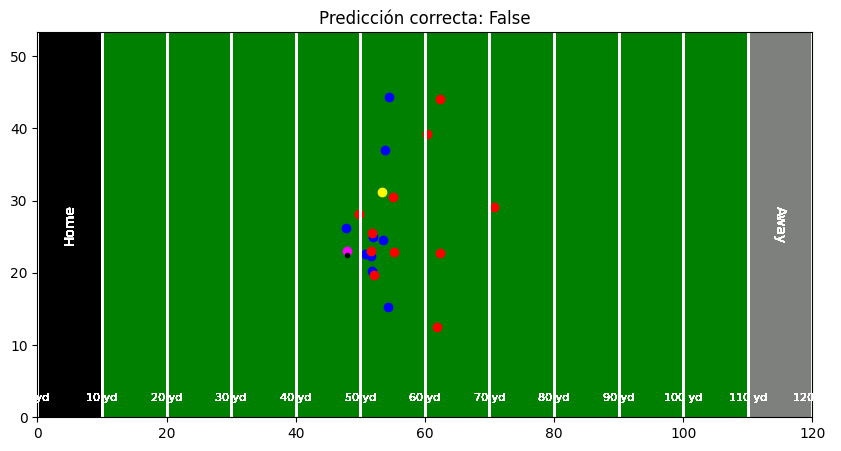

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Función para crear el campo de fútbol americano
def create_football_field():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_facecolor('green')
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)

    # Representación yardas
    for yard_line in range(0, 130, 10):
        color = 'white' if yard_line % 10 == 0 else 'green'
        plt.axvline(x=yard_line, color=color, linestyle='-', linewidth=2, alpha=0.3)
        plt.text(yard_line, 2, f'{yard_line} yd', color='white', ha='center', va='bottom', fontsize=8)

    # Zonas de home y away
    plt.axvspan(0, 10, facecolor='blue', alpha=0.3)
    plt.axvspan(110, 120, facecolor='red', alpha=0.3)
    plt.text(5, 26.7, 'Home', color='white', ha='center', va='center', fontsize=10, rotation=90)
    plt.text(115, 26.7, 'Away', color='white', ha='center', va='center', fontsize=10, rotation=-90)

    # Etiquetas y leyenda
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

    return fig, ax

# Supongamos que play56_game1 es el DataFrame con los datos de las jugadas
frames = play['frameId'].unique()
clubs = play['club'].unique()

# Crear el campo de fútbol
fig, ax = create_football_field()

# Función de inicialización
def init():
    return []

# Función de actualización para la animación
def update(frame):
    ax.clear()

    snapshot = play[play['frameId'] == frame]
    for j, (i, row) in enumerate(snapshot.iterrows()):
# Representación yardas
        for yard_line in range(0, 130, 10):
            color = 'white' if yard_line % 10 == 0 else 'green'
            plt.axvline(x=yard_line, color=color, linestyle='-', linewidth=2)
            plt.text(yard_line, 2, f'{yard_line} yd', color='white', ha='center', va='bottom', fontsize=8)

        # Zonas de home y away
        plt.axvspan(0, 10, facecolor='black', alpha=0.3)
        plt.axvspan(110, 120, facecolor='grey', alpha=0.3)
        plt.text(5, 26.7, 'Home', color='white', ha='center', va='center', fontsize=10, rotation=90)
        plt.text(115, 26.7, 'Away', color='white', ha='center', va='center', fontsize=10, rotation=-90)

        if predictions[frame-1] == j:
            color = 'yellow'
            marker = 'o'
        elif real[frame-1] == j:
            color = 'magenta'
            marker = 'o'
        elif row['club'] == clubs[0]:
            color = 'blue'
            marker = 'o'
        elif row['club'] == clubs[2]:
            color = 'red'
            marker = 'o'
        else:
            marker = '.'
            color = 'black'
        ax.scatter(row['x'], row['y'], marker=marker, color=color)
        plt.xlim(0, 120)
        plt.ylim(0, 53.3)
        plt.title(f'Predicción correcta: {predictions[frame-1]==real[frame-1]}')



# Crear la animación
ani = FuncAnimation(fig, update, frames=frames, init_func=init, interval=10000, repeat=False)

# Guardar la animación como GIF
ani.save(f'{idname}.gif', writer='imagemagick', fps=12)

# Mostrar el gráfico
plt.show()